In [5]:
import networkx as nx
import matplotlib.pyplot as plt


In [7]:
g = nx.read_edgelist("decoded.tsv")

print(nx.info(g))

# count the number of nodes

print(g.number_of_nodes())

# number of self-nodes

g.selfloop_edges()

Name: 
Type: Graph
Number of nodes: 4592
Number of edges: 106647
Average degree:  46.4490
4592


<generator object selfloop_edges.<locals>.<genexpr> at 0x0000015088D4EE58>

[]

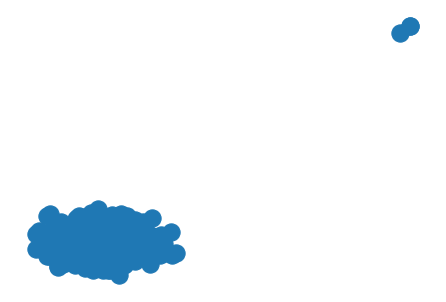

In [10]:
nx.draw(g, pos=nx.spring_layout(g))
plt.plot()